In [1]:
import sklearn
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import re
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect('../db.sqlite3')

In [3]:
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn)

In [4]:
df_raw

,id,kenteken,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,prijs,url,titel,upload_datum,bron,apk
0,1159,96-GZR-3,2008,117910.0,77,0.0,1,1.0,https://www.marktplaats.nl/a/auto-s/fiat/m1554...,Fiat Grande Punto 1.4 Edizione Lusso AUTOMAAT!,2020-05-23 15:01:00,marktplaats,2021-05-22
1,1160,90-ZJ-ZN,2008,169504.0,78,0.0,1,2950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1556...,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...,2020-05-27 13:22:00,marktplaats,2020-10-18
2,1161,03-TR-LV,2007,219718.0,65,1.0,1,1950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,"Fiat Grande Punto 1.2 Edizione Cool AIRCO,CRUI...",2020-06-01 16:00:00,marktplaats,2020-12-12
3,1162,61-TF-FP,2006,199908.0,95,1.0,1,1895.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.4-16V Emotion AIRCO/APK,2020-06-01 14:11:00,marktplaats,2021-01-17
4,1163,62-ZL-SX,2008,138191.0,65,1.0,1,2740.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.2 Active Airco_rijdt prima,2020-06-01 13:56:00,marktplaats,2021-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2017,89-JZL-8,2009,151897.0,77,1.0,1,3955.0,https://www.marktplaats.nl/a/auto-s/fiat/m1560...,Fiat Grande Punto 1.4 NeroBianco | Airco (bj 2...,2020-06-06 11:33:00,marktplaats,2020-09-17
824,2018,25-JGV-4,2009,76004.0,77,0.0,1,4500.0,https://www.marktplaats.nl/a/auto-s/fiat/m1560...,Fiat Grande Punto 1.4 Edizione Lusso Automaat ...,2020-06-06 11:23:00,marktplaats,2020-06-21
825,2019,60-SN-SN,2006,195462.0,65,1.0,1,2499.0,https://www.marktplaats.nl/a/auto-s/fiat/m1560...,Fiat Grande Punto 1.2 8v Sportsound / NAP,2020-06-06 08:25:00,marktplaats,2021-04-28
826,2020,71-PLV-7,2011,145139.0,84,1.0,0,2999.0,https://www.marktplaats.nl/a/auto-s/fiat/m1560...,Fiat Grande Punto 1.3 M-Jet Actual,2020-06-06 08:23:00,marktplaats,2021-02-19


In [5]:
target_names = ["titel", "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "upload_datum", "apk"]

In [6]:
df = df_raw[target_names].dropna(axis=0)
df['upload_datum'] = pd.to_datetime(df['upload_datum'])
df['apk'] = pd.to_datetime(df['apk'])

average_upload_datum = df['upload_datum'].mean().toordinal()
average_apk =df['apk'].mean().toordinal()

def upload_datum_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_upload_datum)
    else:
        return abs(datetime.now().toordinal() - date.toordinal())
    
def apk_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_apk)
    else:  
        return abs(datetime.now().toordinal() - date.toordinal())

df['upload_datum'] = df['upload_datum'].apply(upload_datum_to_ordinal).astype(int)
df['apk'] = df['apk'].apply(apk_to_ordinal).astype(int)

def parse_titel(titel):
    cleaned = re.sub('[^a-zA-Z]+', ' ', titel.lower())
    stripped = line = re.sub(r'\b\w{1,3}\b', '', cleaned)
    
    return stripped

df['titel'] = df['titel'].apply(parse_titel)

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

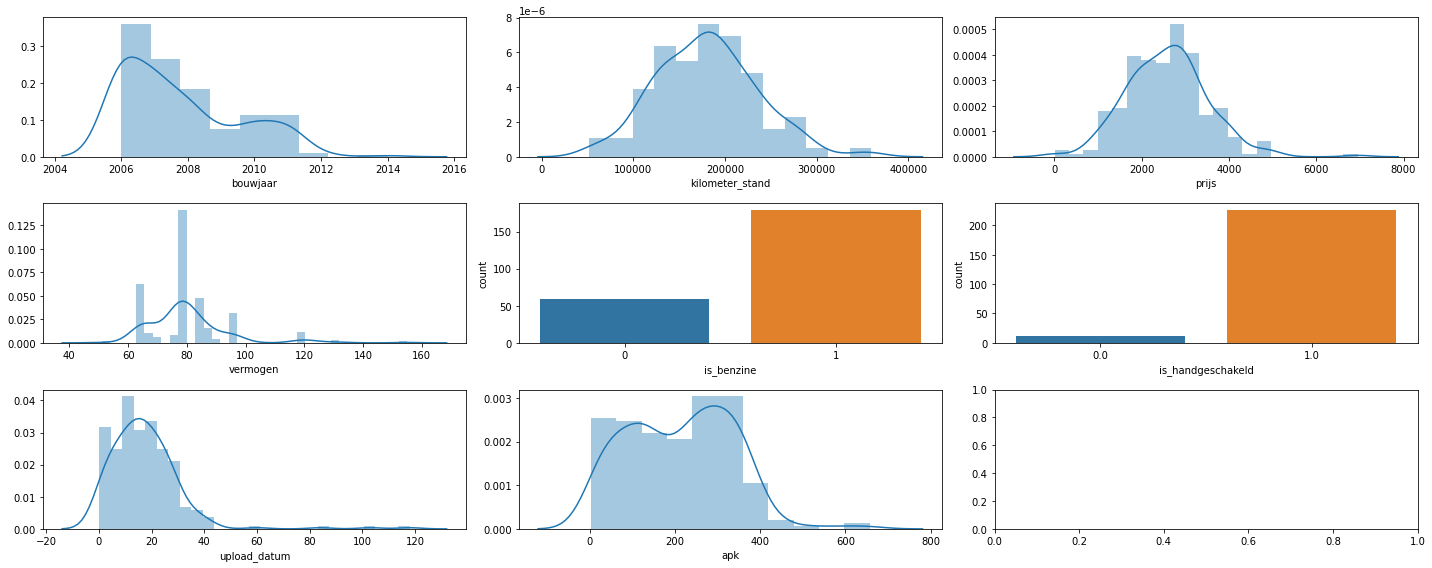

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(20,8))

sns.distplot(df_train['bouwjaar'], ax=axs[0][0]);
sns.distplot(df_train['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df_train['prijs'], ax=axs[0][2]);
sns.distplot(df_train['vermogen'], ax=axs[1][0]);
sns.countplot(df_train['is_benzine'], ax=axs[1][1]);
sns.countplot(df_train['is_handgeschakeld'], ax=axs[1][2]);
sns.distplot(df_train['upload_datum'], ax=axs[2][0]);
sns.distplot(df_train['apk'], ax=axs[2][1]);

plt.tight_layout()

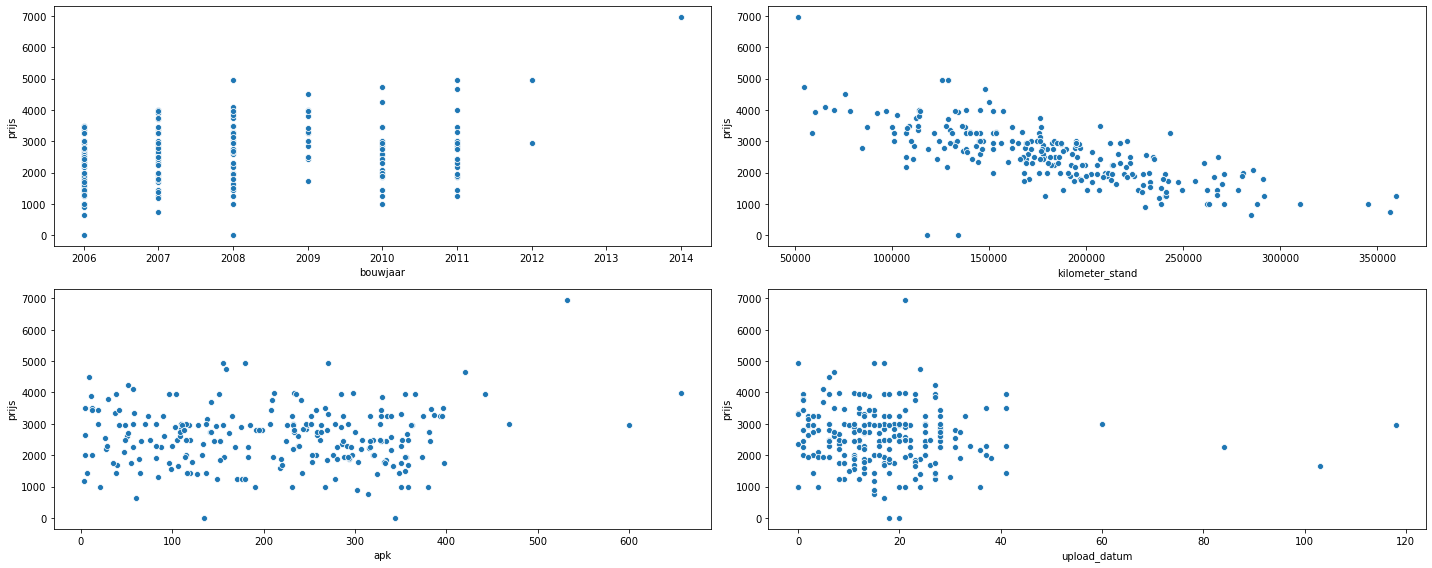

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))

col = 'bouwjaar'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][0]);

col = 'kilometer_stand'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0][1]);

col = 'apk'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][0]);

col = 'upload_datum'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1][1]);

plt.tight_layout()

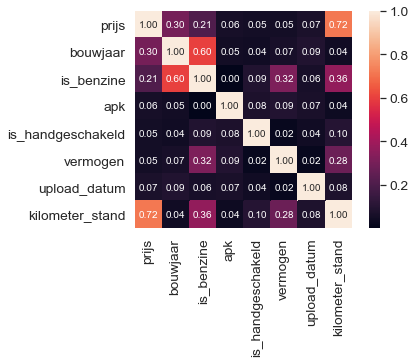

In [10]:
k = 10
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'prijs')['prijs'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(np.absolute(cm), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [11]:
df_train.to_pickle("./train_data.pkl")
df_test.to_pickle("./test_data.pkl")